In order to calculate automatically the percentage of each water disribution surface, you need the original image (eventually) and a set of colors (the legend). 

The model is trained based on the colors in the legend and then it detects automatically the colors displayed in the original image. 

# Prepare the libraries

---



In [ ]:
import numpy as np
import matplotlib.pyplot as plt 
import cv2 
import pandas as pd
import glob

# Read the legend and the original image
---

In [ ]:
name = 'U_Bloc 1_55.5'

# This is the original image
img2 = cv2.imread(name +'.png')
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

# This is a legend of the colors displayed in the original image
colors = cv2.imread('colors.png')
colors = cv2.cvtColor(colors, cv2.COLOR_BGR2RGB)

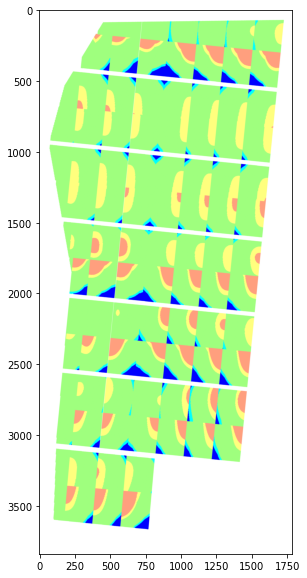

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(img2)

# KMeans clustering for image segmentation
---

In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=6, n_init=10, random_state=1)

def prepare_image(img):
  '''
  This function extracts, from an image of size (n,p), the 3 channels RGB and concatenate them as features in a new matrix of size (n*p , 3)
  '''
  # la transformer en grayscale
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  rouge = img[:,:,0]
  vert = img[:,:,1]
  bleu = img[:,:,2]

  # For Kmeans Segmentation 
  n,p = gray.shape
  size = n * p
  R = rouge.flatten()
  G = vert.flatten()
  B= bleu.flatten()

  R = np.reshape(R, (size,1))
  G = np.reshape(G, (size,1))
  B = np.reshape(B, (size,1))

  image = np.concatenate((R,G,B), axis=1)
  return image

def segment_image(img, colors):
  '''This function segment the original image based on a set of colors (legend)'''
  kmeans = KMeans(n_clusters=6, n_init=10, random_state=1)
  train = prepare_image(colors)
  test = prepare_image(img)
  
  model = kmeans.fit(train)
  labels_test = model.predict(test)
  
  segmented_test = np.reshape(labels_test, img.shape[:2])
  segmented_train = np.reshape(model.labels_, colors.shape[:2])

  blue_c = segmented_train[100,0]
  light_blue_c = segmented_train[200,0]
  green_c = segmented_train[400,0]
  yellow_c = segmented_train[600,0]
  red_c = segmented_train[800,0]
  background_c = segmented_train[0,200]
  black_c = segmented_train[900,100]

  all_parcel = (segmented_test == background_c) == 0
  green = segmented_test == green_c
  red = segmented_test == red_c
  light_blue = segmented_test == light_blue_c
  yellow = segmented_test == yellow_c
  blue = segmented_test == blue_c
  black = segmented_test == black_c

  return all_parcel, green, red, light_blue, yellow, blue, black

In [ ]:
all_parcel, green, red, light_blue, yellow, blue = segment_image(img2, colors)

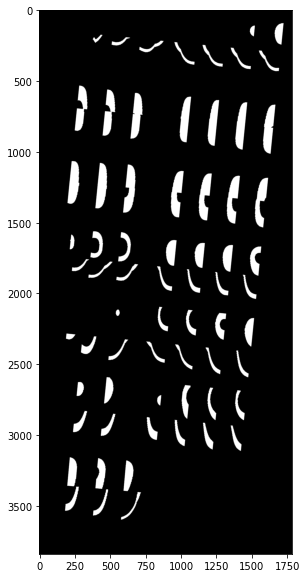

In [ ]:
plt.figure(figsize= (10,10))
plt.imshow(yellow, cmap='gray')

# Calculate area
---

In [ ]:
import pandas as pd 


def calcul_surface(images):
  '''
  This function calculates the surface using the list of sub-images
  '''
  surfaces = []
  for img in images : 
    surfaces.append(np.sum(img))
  return surfaces

def calcul_percentage(images):
  '''
  This function calculates the percentages of each color considering the total surface of the farm
  '''
  percentages = []
  surfaces = calcul_surface(images)
  S_all_parcel = surfaces[0]

  for img in surfaces[1:]: 
    percentages.append(np.round((img) / S_all_parcel , 3))
  return percentages

percentages = calcul_percentage(images)
surfaces = calcul_surface(images)

areas = pd.DataFrame([percentages, surfaces[1:]], columns=['Green', 'Blue', 'Light blue', 'Red', 'Yellow'], index = ['Percentage of area', 'Surfaces'])

areas.to_excel(name+ ".xls")

# Main function

---



In [ ]:
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt 
import cv2 
import pandas as pd
import glob
import os
from skimage import morphology 

square = np.ones((3,3))

def prepare_image(img):
  '''
  This function extracts, from an image of size (n,p), the 3 channels RGB and concatenate them as features in a new matrix of size (n*p , 3)
  '''
  # la transformer en grayscale
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  rouge = img[:,:,0]
  vert = img[:,:,1]
  bleu = img[:,:,2]

  # For Kmeans Segmentation 
  n,p = gray.shape
  size = n * p
  R = rouge.flatten()
  G = vert.flatten()
  B= bleu.flatten()

  R = np.reshape(R, (size,1))
  G = np.reshape(G, (size,1))
  B = np.reshape(B, (size,1))

  image = np.concatenate((R,G,B), axis=1)
  return image

def segment_image(img, colors):
  '''This function segment the original image based on a set of colors (legend)'''

  kmeans = KMeans(n_clusters=7, n_init=10, random_state=1)
  train = prepare_image(colors)
  test = prepare_image(img)
  
  # Here we train the KMeans model using the set of colors (legend)
  model = kmeans.fit(train)
  labels_test = model.predict(test)
  
  # Here we restore the original shape of the segmented images (both the legend and the original image)
  segmented_test = np.reshape(labels_test, img.shape[:2])
  segmented_train = np.reshape(model.labels_, colors.shape[:2])

  # Here we fix the colors displayed in the legend to have a correct mapping between the colors of clusters returned by KMeans and the colors of the original image
  blue_c = segmented_train[100,0]
  light_blue_c = segmented_train[200,0]
  green_c = segmented_train[400,0]
  yellow_c = segmented_train[600,0]
  red_c = segmented_train[800,0]
  background_c = segmented_train[0,200]
  black_c = segmented_train[900,100]

  # Here, we seperate the clusters (colors) from the segmented image. Each sub-image contains a certain color.
  all_parcel = morphology.binary_opening(((segmented_test == background_c) | (segmented_test == black_c)) ==0)
  green = segmented_test == green_c
  red = segmented_test == red_c
  light_blue = segmented_test == light_blue_c
  yellow = segmented_test == yellow_c
  blue = segmented_test == blue_c
  black = segmented_test == black_c

  # return all the sub-images as a list
  return [all_parcel, green, blue, light_blue, red, yellow, black]


def calcul_surface(images):
  '''
  This function calculates the surface using the list of sub-images
  '''
  black = np.sum(images[6])
  scale = 625 / black

  surfaces = []
  for img in images : 
    surfaces.append(np.sum(img)*scale* 0.0001)
  
  return surfaces

def calcul_percentage(images):
  '''
  This function calculates the percentages of each color considering the total surface of the farm
  '''
  percentages = []
  surfaces = calcul_surface(images)
  S_all_parcel = surfaces[0]

  for img in surfaces[1:6]: 
    percentages.append(np.round((img) / S_all_parcel , 3))
  return percentages

colors = cv2.imread('colors.png')
colors = cv2.cvtColor(colors, cv2.COLOR_BGR2RGB)

# Automate the process for all the images, save the data in an Excel file and return it to the user
for map in glob.glob('/content/*.png'):
  base = os.path.basename(map)
  name = os.path.splitext(base)[0]
  if name != 'colors' : 
    img2 = cv2.imread(name +'.png')
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
    
    images = segment_image(img2, colors)
    percentages = calcul_percentage(images)
    surfaces = calcul_surface(images)
    areas = pd.DataFrame([percentages, surfaces[1:6]], columns=['Green', 'Blue', 'Light blue', 'Red', 'Yellow'], index = ['Percentage of area', 'Surfaces (Ha)'])
    areas.to_excel(name+ ".xls")